In [12]:
from google.colab import files
import io
import os
import glob
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
import scipy.optimize as optimize
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

In [13]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The evolutionary trajectories of 50 random couples from a mock simulation under the cost-precision trade-off are imported

In [14]:
data_mixed = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures/Full_data_WGD/data_Mixed_Bm1_full.csv')

As well as for the same simulation without the cost-precision constraints:

In [15]:
data_minimal = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures/Full_data_WGD/data_minimal_Bm1_full.csv')

In [16]:
# Definition of functions to plot all trajectories for one property on the
# same figure (with the appropriate color code, so that the most expressed copy
# is in orange and the least expressed one is in blue)
def calc_changes(sim_data):
  """Function to prepare the simulation data for the later plotting of all
  trajectories
  
  sim_data = dataframe of expression throughout the mutation-selection rounds"""

  # 1) Compute log2 fold-changes
  init_rates = sim_data[sim_data['Round'] == 0].copy()
  n_rounds = sim_data['Round'].max() + 1
  init_tiled = np.tile(init_rates, (n_rounds, 1))

  sim_log2 = sim_data.copy()

  sim_log2.iloc[:, 2:8] = sim_log2.iloc[:, 2:8] / init_tiled[:, 2:8]
  sim_log2.iloc[:, 2:8] = np.log2(sim_log2.iloc[:, 2:8])

  # 2) Identify the most expressed copy within each pair
  last_round = sim_data['Round'].max()
  end_data = sim_data[sim_data['Round'] == last_round]

  # Couples where the most expressed paralog (P1) is identified as P1
  P1_left = np.where(end_data['Prot1'] >= end_data['Prot2'])

  # Couples where the most expressed paralog (P1) is identified as P2
  P1_right = np.where(end_data['Prot2'] >= end_data['Prot1'])

  # 3) Aggregating data for P1 and P2 through time
  means_P1 = pd.DataFrame(columns=['Round', 'Couple', 'Bm', 'Bp', 'Prot', 
                                     'cv'])
  means_P2 = means_P1.copy()

  for P1 in list(P1_left[0]):
    subset = sim_log2[sim_log2['Couple'] == P1]
    
    P1_subset = subset.iloc[:, np.r_[0:4, 6, 8]].copy()
    P2_subset = subset.iloc[:, np.r_[0, 1, 4, 5, 7, 9]].copy()
    P1_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']
    P2_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']

    means_P1 = pd.concat([means_P1, P1_subset])
    means_P2 = pd.concat([means_P2, P2_subset])

  for P1 in list(P1_right[0]):
    subset = sim_log2[sim_log2['Couple'] == P1]

    P1_subset = subset.iloc[:, np.r_[0, 1, 4, 5, 7, 9]].copy()
    P2_subset = subset.iloc[:, np.r_[0:4, 6, 8]].copy()
    P1_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']
    P2_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']

    means_P1 = pd.concat([means_P1, P1_subset])
    means_P2 = pd.concat([means_P2, P2_subset])

  # 4) Computing the means
  means_both = pd.concat([means_P1, means_P2])
  means_both.iloc[:, 2:] = 2**means_both.iloc[:, 2:8]
  means_both = means_both.groupby(by='Round', as_index=False).mean()
  means_both.iloc[:, 1:] = np.log2(means_both.iloc[0:, 1:7])

  means_P1.iloc[:, 2:] = 2**means_P1.iloc[:, 2:8]
  means_P1 = means_P1.groupby(by='Round', as_index=False).mean()
  means_P1.iloc[:, 1:] = np.log2(means_P1.iloc[0:, 1:7])

  means_P2.iloc[:, 2:] = 2**means_P2.iloc[:, 2:8]
  means_P2 = means_P2.groupby(by='Round', as_index=False).mean()
  means_P2.iloc[:, 1:] = np.log2(means_P2.iloc[0:, 1:7])

  return sim_log2, P1_left, P1_right, means_P1, means_P2, means_both


def div_fig(sim_log2, P1_left, P1_right, means_P1, means_P2, means_both,
            gene_prop, ax):
  """Function to plot the evolutionary trajectories throughout the 
  mutation-selection rounds.
  
  sim_log2 = dataframe of log2 fold-changes at each mutation-selection round
  gene_prop = string representing the property to be plotted (either Bm, Bp,
             Prot or cv)
  ax = ax object on which to plot"""

  col_P1 = f'{gene_prop}1'
  col_P2 = f'{gene_prop}2'
  
  # Trajectories are plotted
  widths = 0.10
  opacity = 0.5
  
  for P1 in list(P1_left[0]):
    # Here, paralog 1 (most expressed) is on the left of the df
    subset = sim_log2[sim_log2['Couple'] == P1].copy()
    
    ax.plot(subset['Round'], subset[col_P1], c=cm.tab20.colors[3], 
            alpha=opacity, linewidth=widths)
    ax.plot(subset['Round'], subset[col_P2], c=cm.tab20.colors[1], 
            alpha=opacity, linewidth=widths)
    
  for P1 in list(P1_right[0]):
    # Here, paralog 1 (most expressed) is on the right of the df (identified as '2')
    subset = sim_log2[sim_log2['Couple'] == P1].copy()
    
    ax.plot(subset['Round'], subset[col_P2], c=cm.tab20.colors[3], 
            alpha=opacity, linewidth=widths)
    ax.plot(subset['Round'], subset[col_P1], c=cm.tab20.colors[1], 
            alpha=opacity, linewidth=widths)
    
  # Mean for P1
  ax.plot(means_P1['Round'], means_P1[gene_prop], c=cm.tab10.colors[1], 
          label='Most expressed')

  # Mean for P2
  ax.plot(means_P2['Round'], means_P2[gene_prop], c=cm.tab10.colors[0], 
          label='Least expressed')

  # Global mean
  ax.plot(means_both['Round'], means_both[gene_prop], c='k', label='All',
          alpha=0.65)

In [17]:
# Preparing the data
mixed_ready = calc_changes(data_mixed)

The distributions of the final log2 fold-changes for the same mock simulations are also used

In [18]:
# Function to compute log2 fold-changes between two paralogs
def fold_change(prop_P1, prop_P2, data):
    """Function to calculate log2 fold-change for a property between two duplicates. The two properties are
    provided as dataframe columns, and a dataframe column containing the log2 fold-changes is returned."""

    df = data[[f'{prop_P1}', f'{prop_P2}']].copy()
    df['Fold_Change'] = np.NaN

    for row in range(df.shape[0]):
        value_P1 = df.at[row, f'{prop_P1}']
        value_P2 = df.at[row, f'{prop_P2}']

        if value_P1 == 0 or value_P2 == 0:
            continue

        if value_P1 >= value_P2:
            df.at[row, 'Fold_Change'] = value_P1/value_P2

        elif value_P1 < value_P2:
            df.at[row, 'Fold_Change'] = value_P2/value_P1

    df['Fold_Change'] = np.log2(df['Fold_Change'])

    return df['Fold_Change']

In [19]:
mock_final = data_mixed[data_mixed['Round'] == data_mixed['Round'].max()].copy().reset_index(drop=True)

mock_final[r"$\beta_m$"] = fold_change('Bm1', 'Bm2', mock_final)
mock_final[r"$\beta_p$"] = fold_change('Bp1', 'Bp2', mock_final)
mock_final[r"$P$"] = fold_change('Prot1', 'Prot2', mock_final)

folds_mock = mock_final[[r"$\beta_m$", r"$\beta_p$", r"$P$"]].copy()
folds_mock = folds_mock.melt(var_name='Property', value_name=r"$Log_2$ fold-change")

The final figure is constructed:

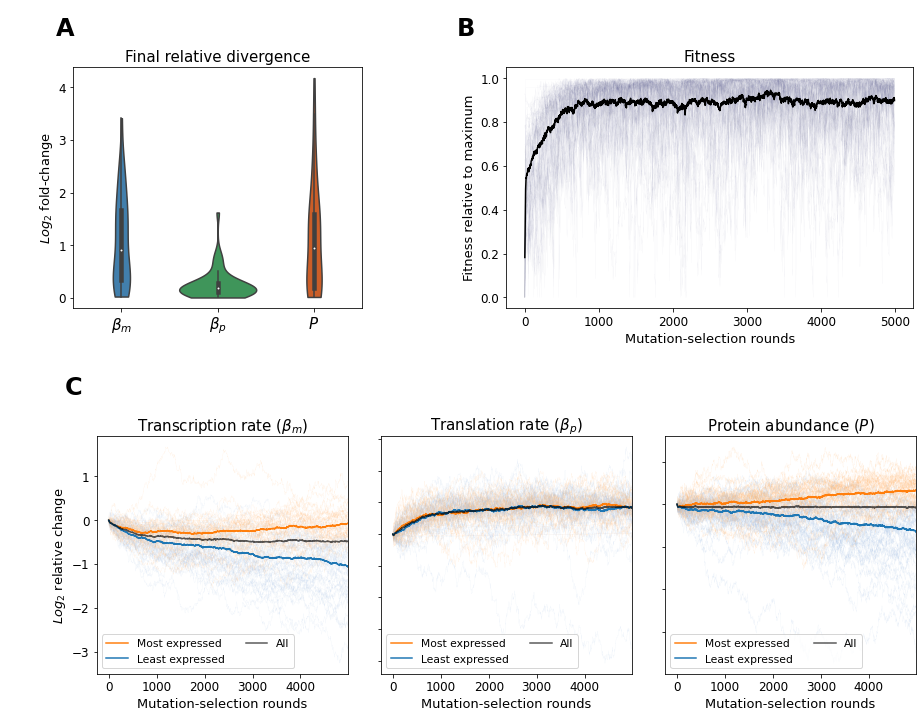

In [11]:
fig = plt.figure(constrained_layout=False, figsize=(17, 10))

# Preparation of the grids
gs1 = fig.add_gridspec(nrows=8, ncols=8, left=0.08, right=0.35, bottom=0.50, 
                       top=0.95, wspace=0.05)
ax1 = fig.add_subplot(gs1[1:7, 1:8])

gs2 = fig.add_gridspec(nrows=8, ncols=8, left=0.42, right=0.8, bottom=0.50, 
                       top=0.95, wspace=0.05)
ax2 = fig.add_subplot(gs2[1:7, 1:8])

gs3 = fig.add_gridspec(nrows=2, ncols=33, left=0.03, right=0.88, bottom=0.05, 
                       top=0.38, wspace=0.05)
ax3 = fig.add_subplot(gs3[:, 4:12])
ax4 = fig.add_subplot(gs3[:, 13:21])
ax5 = fig.add_subplot(gs3[:, 22:30])

# Final relative divergence for the mock simulation 
sns.violinplot(x='Property', y=r"$Log_2$ fold-change", data=folds_mock,
               cut=0, order=[r"$\beta_m$", r"$\beta_p$", r"$P$"],
               palette=[cm.tab20c.colors[0], cm.tab20c.colors[8],
                        cm.tab20c.colors[4]], ax=ax1)

ax1.set_ylabel(r"$Log_2$ fold-change", fontsize=13)
ax1.set_xlabel('')

# Fitness through time
rel_fit = pd.DataFrame(columns=data_mixed.columns)
for pair in data_mixed['Couple'].unique():
  pair_sub = data_mixed[data_mixed['Couple'] == pair].copy()
  pair_sub['Fitness'] = (pair_sub['Fitness'] - pair_sub['Fitness'].min())/(pair_sub['Fitness'].max() - pair_sub['Fitness'].min())

  rel_fit = pd.concat([rel_fit, pair_sub], axis=0)

  ax2.plot(pair_sub['Round'], pair_sub['Fitness'], c=cm.tab20b.colors[0],
           alpha=0.15, linewidth=0.075)
  
# Addition of the mean
data_mean = rel_fit.groupby(by='Round', as_index=False).mean()
ax2.plot(data_mean['Round'], data_mean['Fitness'], c='k')

# Divergence through time for the mock simulation under the cost-precision
# trade-off
div_fig(mixed_ready[0], mixed_ready[1], mixed_ready[2], mixed_ready[3], 
        mixed_ready[4], mixed_ready[5], 'Bm', ax3)

div_fig(mixed_ready[0], mixed_ready[1], mixed_ready[2], mixed_ready[3], 
        mixed_ready[4], mixed_ready[5], 'Bp', ax4)

div_fig(mixed_ready[0], mixed_ready[1], mixed_ready[2], mixed_ready[3], 
        mixed_ready[4], mixed_ready[5], 'Prot', ax5)

ax3.legend(fontsize=10.75, ncol=2)
ax4.legend(fontsize=10.75, ncol=2)
ax5.legend(fontsize=10.75, ncol=2)

# Manual corection of y axes
for ax in [ax4, ax5]:
  ax.set_ylabel('')
  ax.tick_params(labelleft=False)

# Axes labels
ax2.set_xlabel(r'Mutation-selection rounds', fontsize=13)
ax2.set_ylabel('Fitness relative to maximum', fontsize=13)

ax3.set_ylabel(r"$Log_2$ relative change", fontsize=13)

ax3.set_xlabel('Mutation-selection rounds', fontsize=13)
ax4.set_xlabel('Mutation-selection rounds', fontsize=13)
ax5.set_xlabel('Mutation-selection rounds', fontsize=13)

# Manual setting of the xlims
for ax in [ax3, ax4, ax5]:
    ax.set_xlim(right=data_mixed['Round'].max())

# Manual setting of tick labels
for ax in [ax1, ax2, ax3, ax4, ax5]:
  ax.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(axis='x', which='major', labelsize=15)

# Plot titles
ax1.set_title('Final relative divergence', fontsize=15)
ax2.set_title('Fitness', fontsize=15)
ax3.set_title(r"Transcription rate ($\beta_m$)", fontsize=15)
ax4.set_title(r"Translation rate ($\beta_p$)", fontsize=15)
ax5.set_title(r"Protein abundance ($P$)", fontsize=15)

# Annotation of subfigures A, B and C
ax1.annotate('A', (0.06, 0.95), xycoords='figure fraction',
             fontsize=24, fontweight="bold")

ax2.annotate('B', (0.495, 0.95), xycoords='figure fraction',
             fontsize=24, fontweight="bold")

ax3.annotate('C', (0.07, 0.45), xycoords='figure fraction',
             fontsize=24, fontweight="bold")

# Saving the figure
Fig3 = plt.gcf()
Fig3.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/Fig3_final.pdf',
             bbox_inches='tight')

Addition: Is transcriptional divergence under the cost-precision trade-off really adaptive?

Because the simulations conflate the optimization of cumulative expression, the rebalancing the Bp-Bm ratio and the expression divergence, it is better to consider an idealized (already optimal) paralog pair:

In [ ]:
# Previously defined fitness functions are added
def variance_dupli(bm1, bm2, p1, p2, alpha_p, cv_0):
    """Function to compute the variance of protein abundance for many duplicate couples at once. The transcription rates
    (bm1 and bm2) and protein abundances (p1 and P2) for each couple are provided as np arrays and an array containing
     the variances for each couple is returned. The variables alpha_p and cv_0 are constants (protein decay rate and
     noise floor) and only need to be provided as floats. It is used in the fit_noise_dupli function below.

    bm1, bm2 = Transcription rate of paralogs P1 and P2, respectively (in mRNA per hour)
    p1, p2 = Protein abundance of paralogs P1 and P2, respectively (in proteins per cell)"""

    with np.errstate(divide='ignore', invalid='ignore'):
        # To avoid warnings raised when p1 == 0 or p2 == 0, since np.where first applies the operation to all elements
        # before testing the condition
        intrinsic_p1 = np.where(p1 == 0, 0, (p1**2) * ((1/p1) + (alpha_p/bm1)))
        intrinsic_p2 = np.where(p2 == 0, 0, (p2**2) * ((1/p2) + (alpha_p/bm2)))

    extrinsic_tot = (np.sqrt((p1**2) * (cv_0**2)) + np.sqrt((p2**2) * (cv_0**2)))**2
    var_tot = intrinsic_p1 + intrinsic_p2 + extrinsic_tot

    return var_tot


def fit_noise_dupli(bm1, bm2, bp1, bp2, pOpt, Q, alpha_m, alpha_p, cv_0):
    """Function to compute the fitness due to protein abundance for a duplicate couple. Protein abundance fluctuations
    du to expression noise are taken into account, with intrinsic noise being completely decoupled between the two
    paralogs, while extrinsic noise is perfectly correlated between them. The transcription rates of both genes (bm1
    and bm2), their protein abundance (p1 and p2), the optimal cumulative protein abundance (pOpt) and the noise
    sensitivity (Q, curvature of the fitness function) are used. The function is assumed to be parabolic, with an
    optimum at (pOpt, 0.42), where fitness is in 1/hour.

    bm1, bm2 = Transcription rate of paralogs P1 and P2, respectively (in mRNAs per hour)
    bp1, bp2 = Translation rate of paralogs P1 and P2, respectively (in proteins per mRNA per hour)
    pOpt = Optimum of the fitness function of cumulative protein abundance (in proteins per cell)
    Q = Noise sensitivity, as defined by Hausser et al., 2019
    alpha_m = mRNA decay rate (constant, in 1/hour)
    alpha_p = protein decay rate (constant, in 1/hour)
    cv_0 = Noise floor (minimal coefficient of variation of protein abundance), as reported by Hausser et al., 2019"""

    f_d2 = -2*(Q/pOpt)

    p1 = (bm1 * bp1) / (alpha_m * alpha_p)
    p2 = (bm2 * bp2) / (alpha_m * alpha_p)

    # Variance of the protein abundance distribution
    var_tot = variance_dupli(bm1, bm2, p1, p2, alpha_p, cv_0)

    # Parameters of the parabola of fitness according to protein abundance
    a = f_d2/2
    b = -2 * a * pOpt
    c = 0.42 - (a * pOpt ** 2) - (b * pOpt)

    # Mean fitness when expression noise is taken into account
    # E(Fit) = a * E(x**2) + b * E(x) + c
    mean_x2 = var_tot + (p1 + p2)**2
    mean_fit = a*mean_x2 + b*(p1 + p2) + c

    return mean_fit


def fit_global_dupli(bm1, bm2, bp1, bp2, pOpt, Q, alpha_m, alpha_p, cv_0, lm, c_m):
    """Function to compute the fitness (in 1/hour) of a duplicate couple for a given protein abundance,
    taking into account expression noise and transcription costs.

    bm1, bm2 = Transcription rate of paralogs P1 and P2, respectively (in mRNAs per hour)
    bp1, bp2 = Translation rate of paralogs P1 and P2, respectively (in proteins per mRNA per hour
    pOpt = Optimal cumulative protein abundance (in proteins per cell)
    Q = Noise sensitivity, as defined by Hausser et al., 2019
    alpha_m = mRNA decay rate (constant, in 1/hour)
    alpha_p = protein decay rate (constant, in 1/hour)
    cv_0 = Noise floor (minimal coefficient of variation of protein abundance), as reported by Hausser et al., 2019
    lm = Length of the mRNA, assumed to remain equal for both duplicates (in nucleotides)
    c_m = Fitness cost of transcription per nucleotide, as calculated by Hausser et al., 2019 (in 1/hours)"""

    fit_abun = fit_noise_dupli(bm1, bm2, bp1, bp2, pOpt, Q, alpha_m, alpha_p, cv_0)

    exp_cost = c_m * lm * (bm1 + bm2)

    fit_glob = fit_abun - exp_cost

    return fit_glob

In [ ]:
# A function is defined to optimize Bm and Bp for a paralog pair
def dupli_opt(params, pOpt, Q, alpha_m, alpha_p, cv_0, lm, c_m):
    """Function to compute the fitness (in 1/hour) of a duplicate couple for a given protein abundance,
    taking into account expression noise and transcription costs.

    params = Tuple of (Bm, Bp), assuming that the two expression rates are equal
             for both paralogs
    pOpt = Optimal cumulative protein abundance (in proteins per cell)
    Q = Noise sensitivity, as defined by Hausser et al., 2019
    alpha_m = mRNA decay rate (constant, in 1/hour)
    alpha_p = protein decay rate (constant, in 1/hour)
    cv_0 = Noise floor (minimal coefficient of variation of protein abundance), as reported by Hausser et al., 2019
    lm = Length of the mRNA, assumed to remain equal for both duplicates (in nucleotides)
    c_m = Fitness cost of transcription per nucleotide, as calculated by Hausser et al., 2019 (in 1/hours)"""

    bm, bp = params

    fit_abun = fit_noise_dupli(bm, bm, bp, bp, pOpt, Q, alpha_m, alpha_p, cv_0)

    exp_cost = c_m * lm * (bm + bm)

    fit_glob = -1*(fit_abun - exp_cost)

    return fit_glob

In [ ]:
# Optimizing the Bm and Bp rates of a median paralog pair
pOpt = 2*(10**3.58)
Q = 2.618282381589138e-07
alpha_m = 5.1
alpha_p = 1.34
lm = 1350
cv_0 = 0.1
c_m = 1.2e-9

# Approximate optimum
bm_est = math.sqrt(pOpt * alpha_p * alpha_m * (Q / (c_m * lm * alpha_m)))
bm_bounds = (0.1*bm_est, 10*bm_est)

bp_est = (pOpt * alpha_m * alpha_p) / bm_est
bp_bounds = (0.1*bp_est, 10*bp_est)

opt_pair = optimize.differential_evolution(dupli_opt, (bm_bounds, bp_bounds), tol=1e-10,
                                           args=(pOpt, Q, alpha_m, alpha_p, lm, cv_0, c_m))

In [ ]:
# Optimal Bp and Bp
opt_bm = opt_pair['x'][0]*2
opt_bp = opt_pair['x'][1]*0.5

In [ ]:
# Fitness is computed for different levels of transcriptional divergence
Bm_divergence = pd.DataFrame(columns=['Higher Bm Frac', 'Fitness'])
Bm_divergence['Higher Bm Frac'] = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
                                   0.85, 0.90, 0.95]

for row in range(Bm_divergence.shape[0]):
  higher_frac = Bm_divergence.at[row, 'Higher Bm Frac']
  Bm_high = (opt_bm*2) * higher_frac
  Bm_low = (opt_bm*2) * (1 - higher_frac)
  fit = fit_global_dupli(Bm_high, Bm_low, opt_bp, opt_bp, pOpt, Q, alpha_m, 
                         alpha_p, cv_0, lm, c_m)
  Bm_divergence.at[row, 'Fitness'] = 0.42 - fit

In [ ]:
p1 = (Bm_high * opt_bp) / (alpha_m * alpha_p)
p2 = (Bm_low * opt_bp) / (alpha_m * alpha_p)

variance_dupli(Bm_high, Bm_low, p1, p2, alpha_p, cv_0)

2292.525163908892

In [ ]:
Bm_high

15.420616192818027

In [ ]:
Bm_low

0.8116113785693706

In [ ]:
Bm_high = (opt_bm*2) * 0.9
Bm_low = (opt_bm*2) * (1 - 0.9)

p1 = (Bm_high * opt_bp) / (alpha_m * alpha_p)
p2 = (Bm_low * opt_bp) / (alpha_m * alpha_p)

variance_dupli(Bm_high, Bm_low, p1, p2, alpha_p, cv_0)

2292.525163908892

In [ ]:
# Et si on a un seul gène avec la même transcription totale?
(p1+p2)**2 * ((1/(p1+p2)) + (alpha_p/(opt_bm*2)) + 0.1**2)

2292.5251639088924

Est-ce qu'une divergence principalement transcriptionnelle cause une plus grande divergence des niveaux de bruit qu'une divergence symmétrique ou principalement traductionnelle?

In [ ]:
variance_dupli((opt_bm*2), (opt_bm*2), (p1+p2), (p1+p2), alpha_p, cv_0)

5047.591054462524

In [ ]:
10*130

1300

In [ ]:
(1300)**2 * ((1/(1300)) + (alpha_p/(10)) + 0.1**2)

244660.00000000003

In [ ]:
(1300)**2 * ((1/(1300)) + (alpha_p/(20)) + 0.1**2)

131430.00000000003

In [ ]:
p2

15.207575852921781

In [ ]:
int_P1 = (p1**2) * ((1/p1) + (alpha_p/Bm_high))
int_P2 = (p2**2) * ((1/p2) + (alpha_p/Bm_low))
ext = (np.sqrt((p1**2) * (cv_0**2)) + np.sqrt((p2**2) * (cv_0**2)))**2
total = int_P1 + int_P2 + ext

In [ ]:
int_P1

1855.1293205278698

In [ ]:
int_P2

206.12548005865213

In [ ]:
total

2292.525163908892

In [ ]:
total

2292.525163908892

In [ ]:
int_P2 = (p2**2) * ((1/p2) + (alpha_p/Bm_low))

In [ ]:
ext = (np.sqrt((p1**2) * (cv_0**2)) + np.sqrt((p2**2) * (cv_0**2)))**2

In [ ]:
higher_frac

0.95

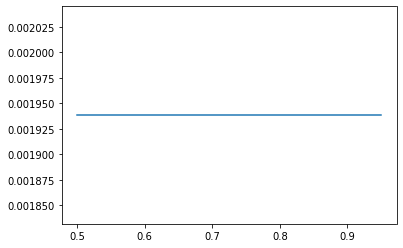

In [ ]:
plt.plot(Bm_divergence['Higher Bm Frac'], Bm_divergence['Fitness'])

In [ ]:
Bm_divergence.at[8, 'Fitness']

0.0019384224441176268

In [ ]:
Bm_divergence.at[0, 'Fitness']

0.0019384224441176268

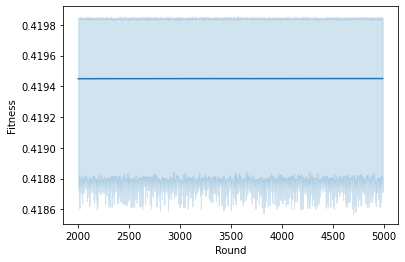

In [ ]:
test_subset = data_mixed[data_mixed['Round'] > 2000]

sns.lineplot(x='Round', y='Fitness', data=test_subset)